In [ ]:
# Conecting to G Drive data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Installing non-standard colab library, having revisited this notebook it seems
# there is some issue caused by tensorflow updates when fitting the autoencoder 
#, therefore we force slightly older versions 
! pip install tensorflow==2.8
! pip install tensorflow_io==0.24.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.4 MB 3.4 MB/s 
     |████████████████████████████████| 2.1 MB 55.7 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.26.0
    Uninstalling tensorflow-io-gcs-filesystem-0.26.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.26.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.26.0
    Uninstalling tensorflow-io-0.26.0:
      Successfully uninstalled tensorflow-io-0.26.0


In [ ]:
# Copying central function library to notebook content area
! cp /content/drive/MyDrive/AAFPG/functions/aafpg_functions.py /content

# Importing functions from content
from aafpg_functions import (get_features, get_tracks, get_tracks_paths_from_dir,
                        get_features_subset, get_tracks_subset, get_genres, 
                        get_tracks_genres_subset, get_genre_top_dict_subset, 
                        genre_id_to_string, play_track, similarity_dict, 
                        cohesive_playlist, progressive_playlist)

In [ ]:
# Importing packages 
# import pandas as pd
# import librosa 
import matplotlib.pyplot as plt
# import numpy as np
# import librosa.display
# import os
# from IPython.display import Audio
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_io as tfio
from tqdm.auto import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Various global params
DIRECTORY  = '/content/drive/MyDrive/AAFPG/fma_small_resaved'
### --- Spectrograms --- ###
TARGET_SAMPLE_RATE = 16000
NFFT=12000
WINDOW=12000
STRIDE=10400

MEL_SCALING = 1100

### --- Dataset --- ###
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
NUM_TARGETS = 8

BUFFER_SIZE = 10
min_first_dim = 1321967

In [ ]:
# Defining functions

def generate_tensor(file_path, min_first_dim=min_first_dim):
    
    audio_tensor = tfio.audio.AudioIOTensor(file_path, dtype='float32')
    return tf.reduce_mean(audio_tensor[:min_first_dim],1)

def generate_mel_spectrogram(file_path, nfft=NFFT, window=WINDOW, stride=STRIDE, min_first_dim=min_first_dim, rate=TARGET_SAMPLE_RATE, mels=32, fmin=0, fmax=TARGET_SAMPLE_RATE/2, scaling=MEL_SCALING):

    tensor = generate_tensor(file_path=file_path, min_first_dim=min_first_dim)
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=rate, mels=mels, fmin=fmin,fmax=fmax)
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
    mel_spectrogram = mel_spectrogram/scaling
    return mel_spectrogram, mel_spectrogram

def generate_spectrogram(file_path, nfft=NFFT, window=WINDOW, stride=STRIDE, min_first_dim=min_first_dim):
    tensor = generate_tensor(file_path = file_path, min_first_dim = min_first_dim)
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    return spectrogram

def generate_dataset(df, directory=DIRECTORY, batch_size=BATCH_SIZE, shuffle=True):

    file_paths = directory + df['path_relative'].values
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths))

    dataset = dataset.map(generate_mel_spectrogram)

    dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(batch_size, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

In [ ]:
# Testing tensor shape generated, first 2 dims need to be of the form n**2 for 
# simple reduction of dimensions 

path = "/content/drive/MyDrive/AAFPG/fma_small_resaved/001039.mp3"
generate_mel_spectrogram(path)[0].shape

TensorShape([128, 32, 1])

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU, UpSampling2D
from tensorflow.keras.optimizers import Adam

def build_encoder(latent_dimension,input_shape):
    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()
    
    encoder.add(Conv2D(8, (5,5),strides=(2,2), input_shape=input_shape, activation='relu',padding='same'))
    
    encoder.add(Conv2D(32, (5, 5),strides=(2,2), activation='relu',padding='same'))

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))

    return encoder

In [ ]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras import Sequential

def build_decoder(latent_dimension):
    decoder = Sequential()
    decoder.add(Dense(32*8*1, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((16, 4, 4)))  # no batch axis here
    decoder.add(Conv2DTranspose(8, (2, 2), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(4, (2, 2), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(1, (2, 2), strides=2, padding='same', activation='relu'))
    return decoder
    

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

def build_autoencoder(encoder, decoder):
    inp = Input((128, 32,1))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

In [ ]:
opt = Adam(lr=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse',
                  optimizer=opt)

In [ ]:

path = '/content/drive/MyDrive/AAFPG/fma_small_resaved'
tracks, paths = get_tracks_paths_from_dir(path)
genre_dict = get_genre_top_dict_subset(path)

In [ ]:
df = get_tracks_genres_subset(path)


In [ ]:
ds_train = generate_dataset(df=df)

In [ ]:
# Setting input shape based on tensor produced and confirming it meets our expectaions 
spect = next(iter(ds_train))[0]
spec_max = tf.math.reduce_max(spect)
input_shape = spect.shape[1:]
input_shape

TensorShape([128, 32, 1])

In [ ]:
# Building encoder

encoder = build_encoder(latent_dimension=256, input_shape=input_shape)
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 16, 8)         208       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 8, 32)         6432      
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
Total params: 2,104,048
Trainable params: 2,104,048
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Setting decoder input shape 

decoder_inp_shape = encoder.output_shape[1:]
decoder_inp_shape = tf.TensorShape(decoder_inp_shape)
decoder_inp_shape

TensorShape([256])

In [ ]:
# Building decoder

decoder = build_decoder(latent_dimension=256)
decoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 reshape (Reshape)           (None, 16, 4, 4)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 8, 8)         136       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 16, 4)        132       
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 32, 1)       17        
 ranspose)                                                       
                                                      

In [ ]:
# Building auto encoder 

autoencoder = build_autoencoder(encoder, decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 32, 1)]      0         
                                                                 
 sequential (Sequential)     (None, 256)               2104048   
                                                                 
 sequential_1 (Sequential)   (None, 128, 32, 1)        66077     
                                                                 
Total params: 2,170,125
Trainable params: 2,170,125
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling autoencoder
compile_autoencoder(autoencoder)

In [ ]:
# Defining .fit parameters

es = EarlyStopping(patience=10,monitor='loss')
mc = ModelCheckpoint(monitor='loss',
    filepath='/content/drive/MyDrive/AAFPG/models/autoencoder/ModelCheckpoints',
    save_weights_only=False,
    mode='max',
    save_best_only=True)

callbacks = [es, mc]

In [ ]:
# Train encoder
autoencoder.fit(ds_train, epochs = 1000, callbacks=callbacks)

Epoch 1/1000
125/125 [==============================] - 19272s 154s/step - loss: 0.5043
Epoch 2/1000
125/125 [==============================] - 1s 7ms/step - loss: 0.3029
Epoch 3/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1798
Epoch 4/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1506
Epoch 5/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1426
Epoch 6/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1343
Epoch 7/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1299
Epoch 8/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1258
Epoch 9/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1252
Epoch 10/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1216
Epoch 11/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1178
Epoch 12/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1

track 0


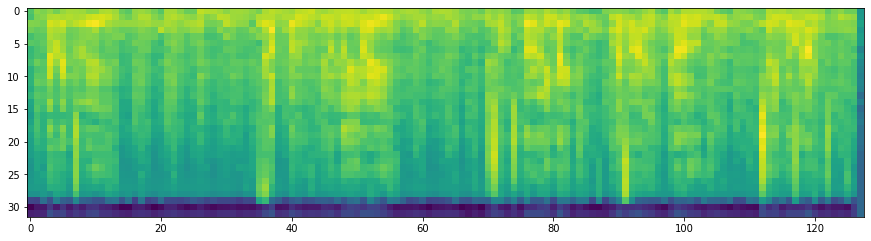

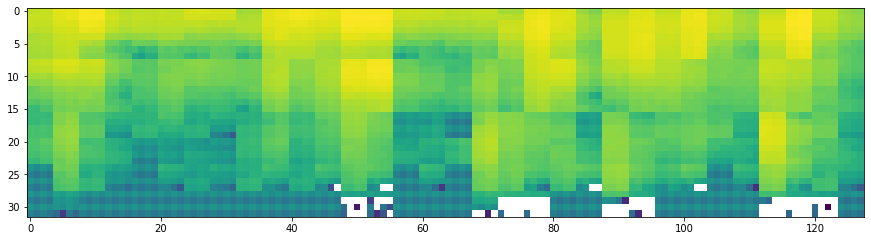



track 1


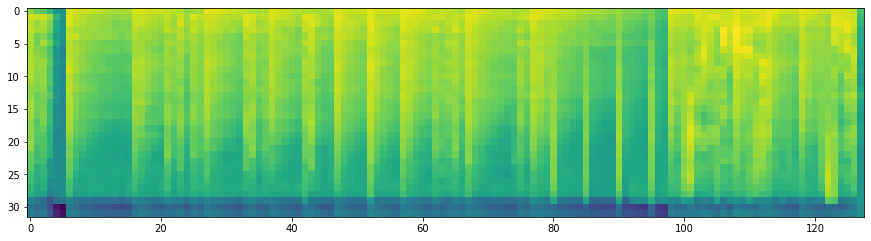

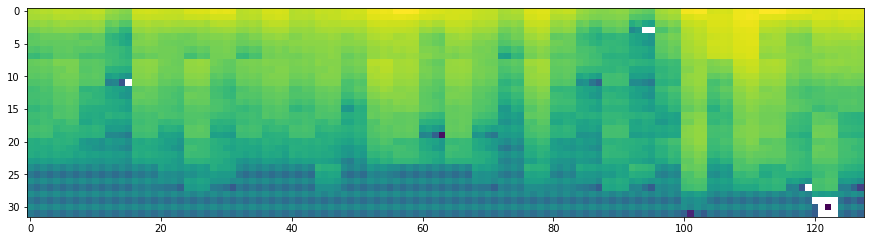



track 2


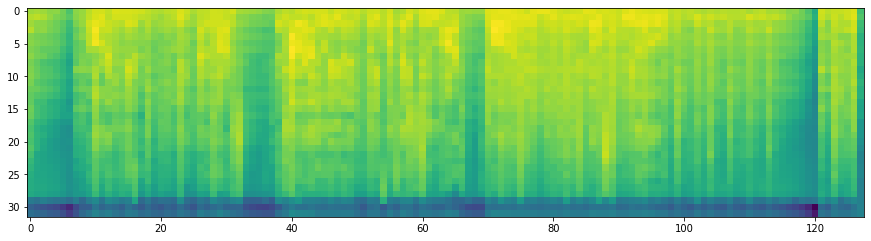

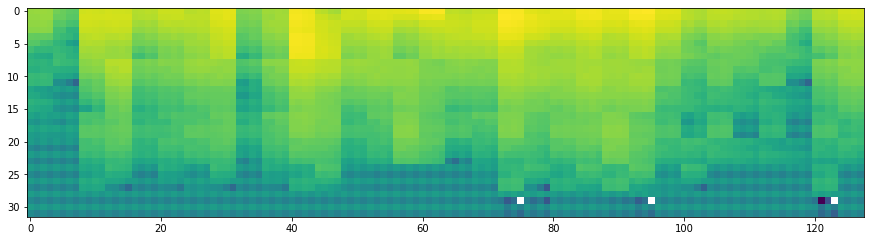



track 3


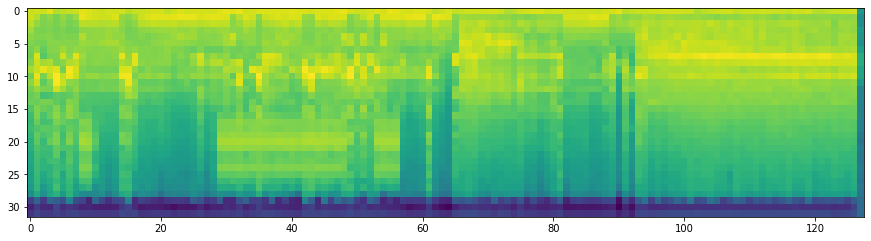

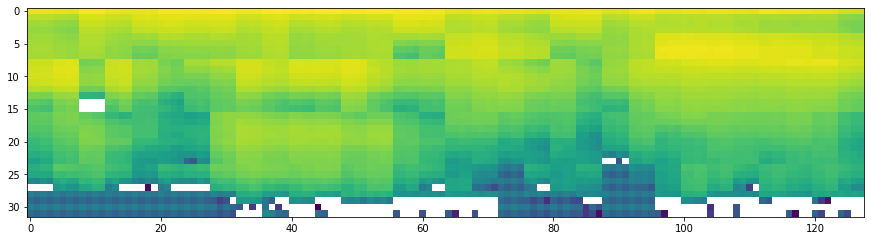



track 4


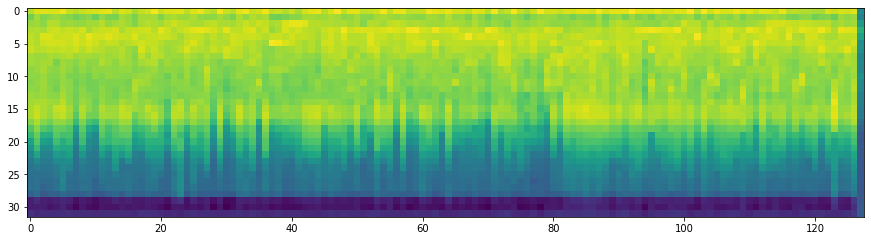

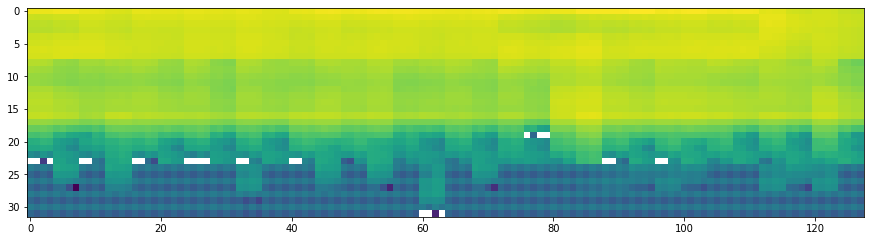



track 5


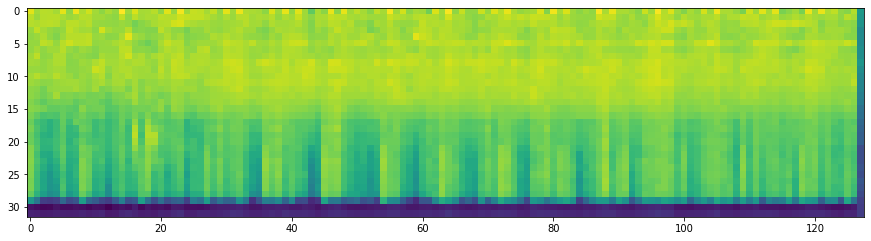

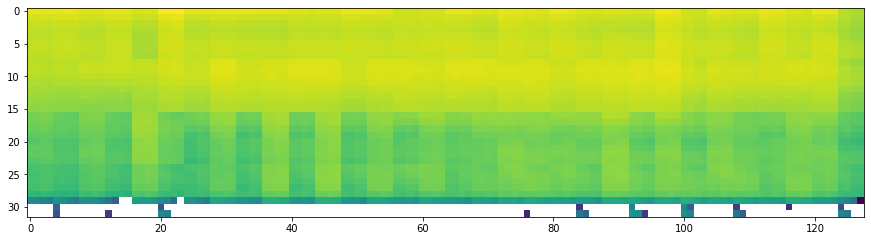



track 6


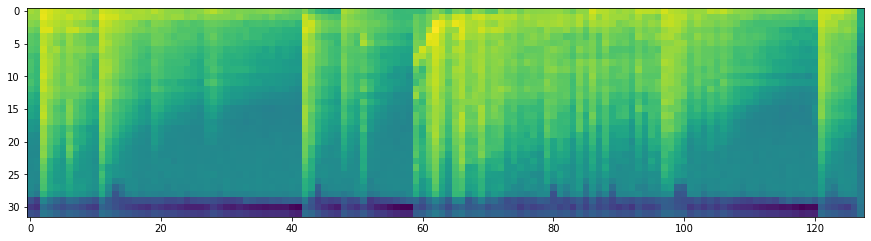

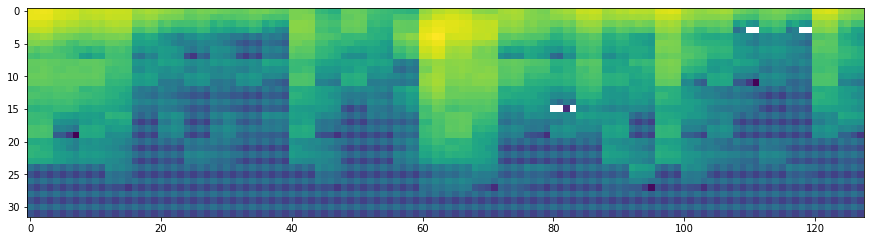



track 7


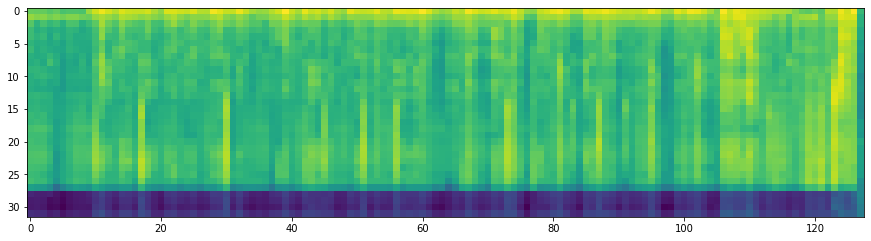

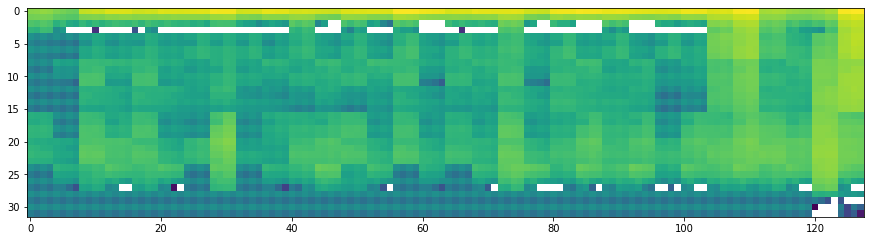



track 8


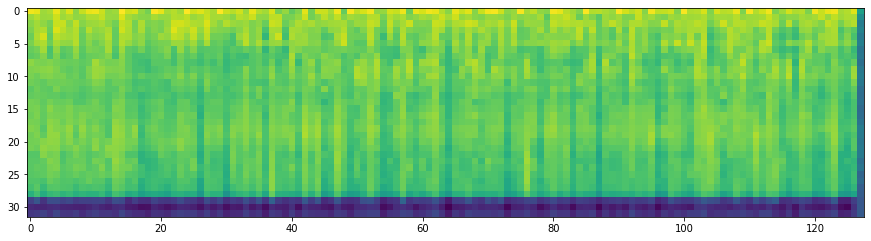

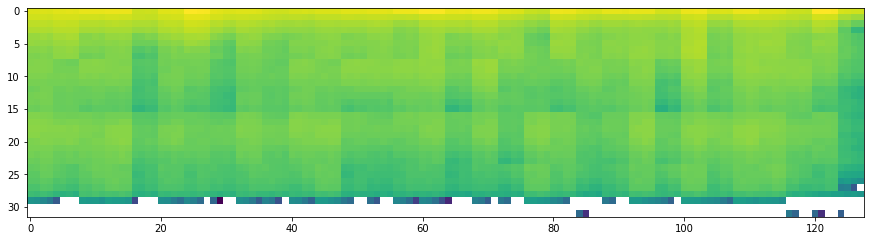



track 9


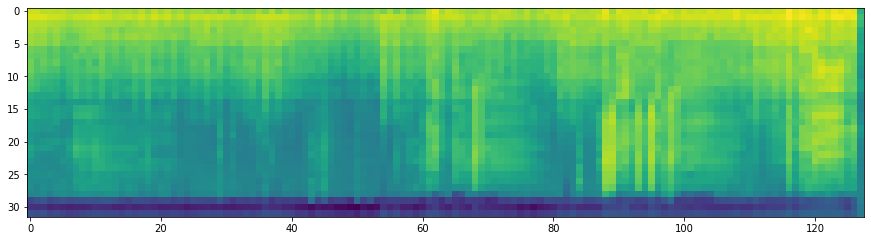

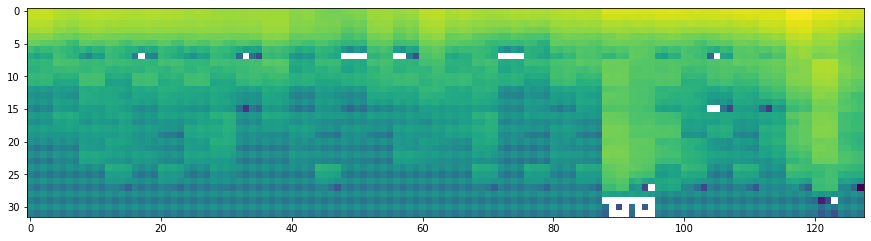



track 10


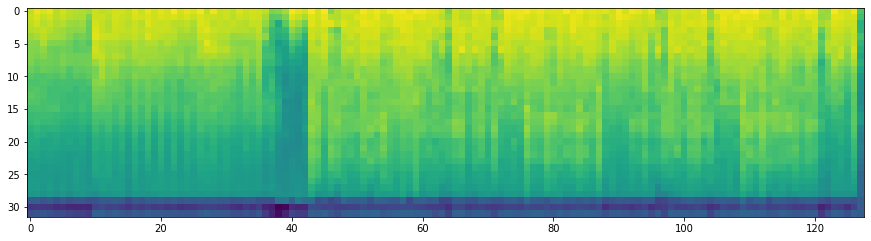

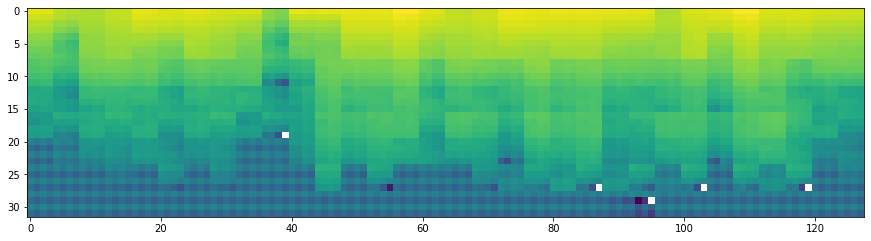



track 11


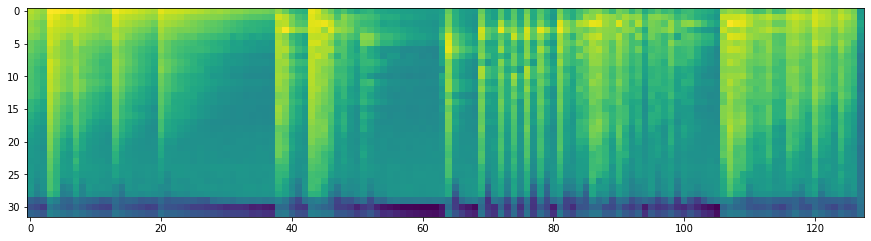

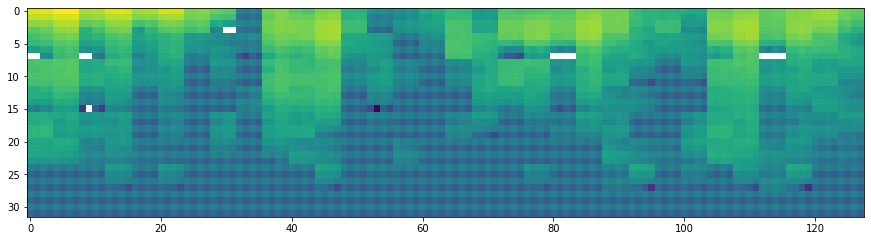



track 12


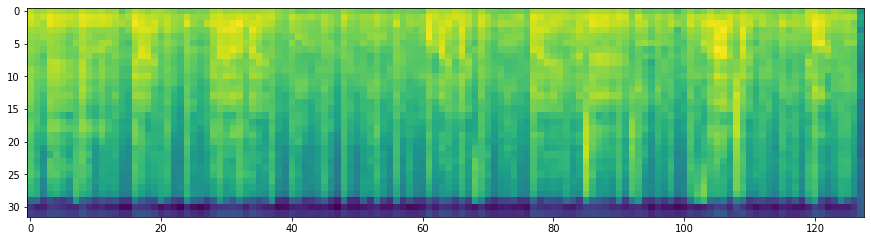

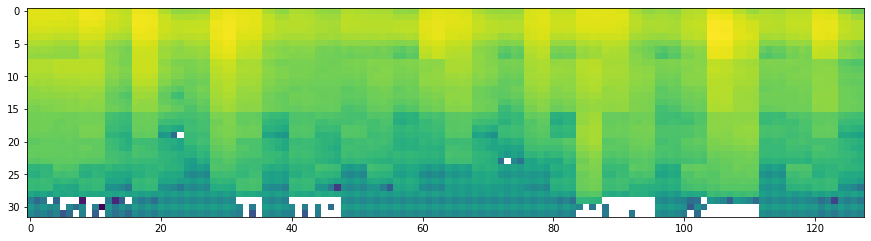



track 13


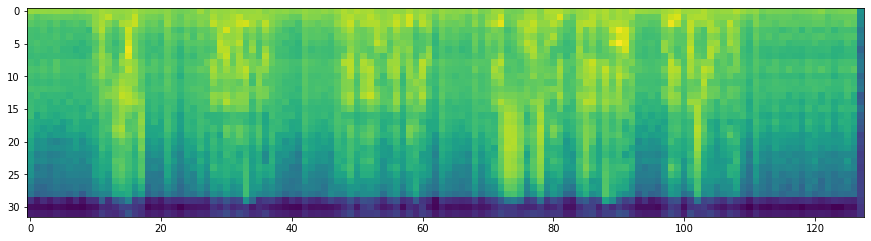

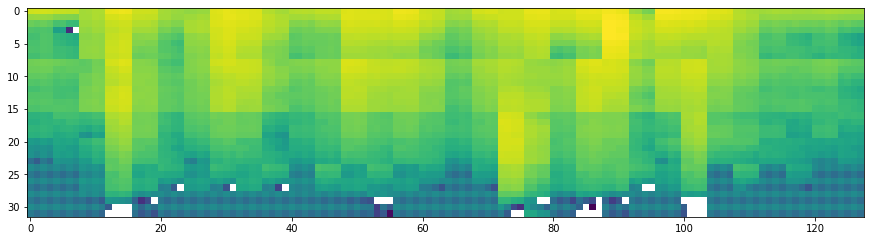



track 14


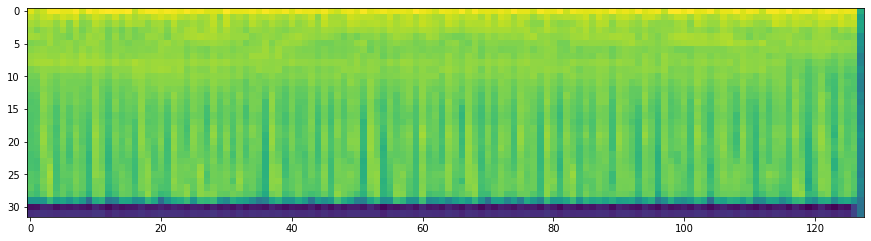

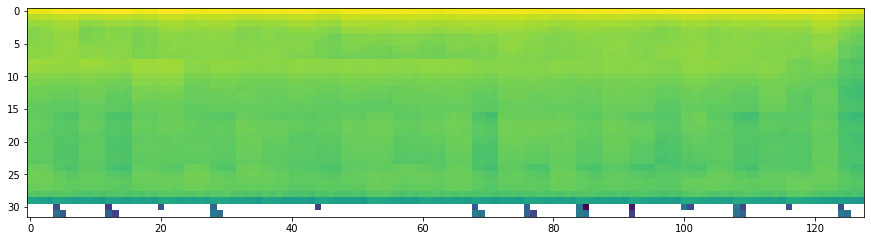



track 15


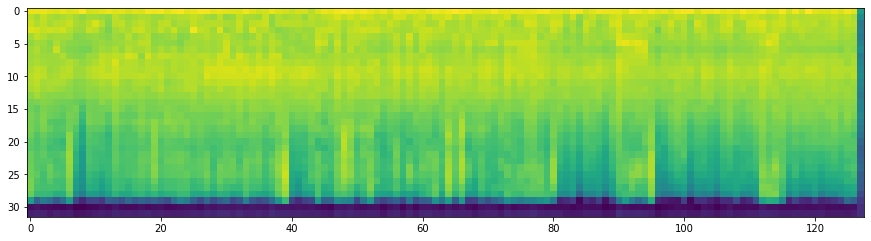

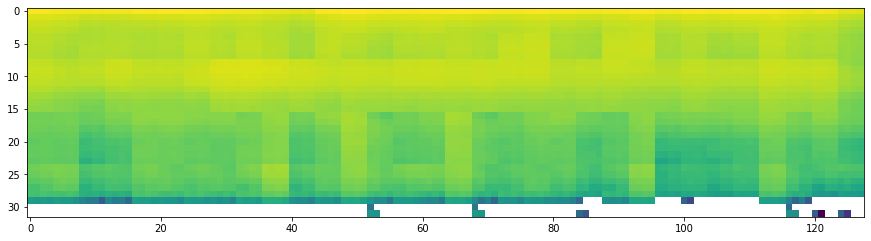



track 16


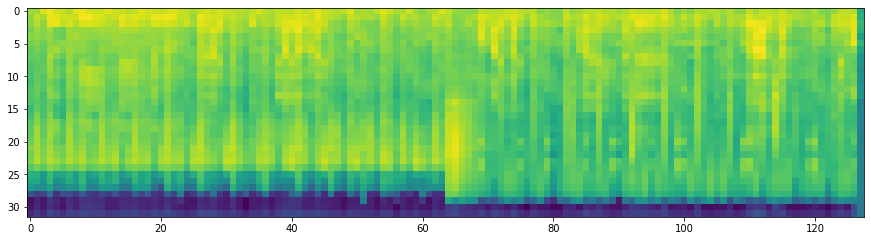

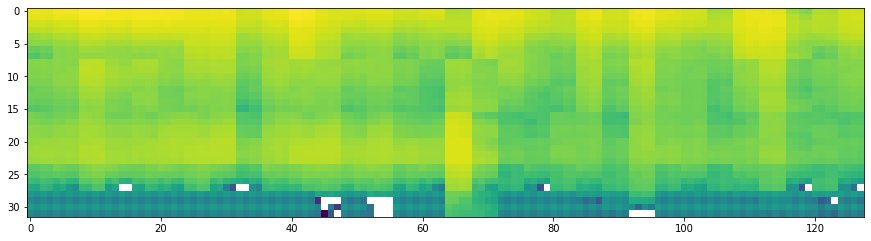



track 17


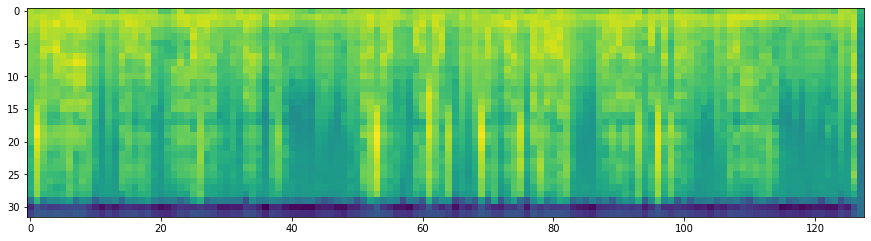

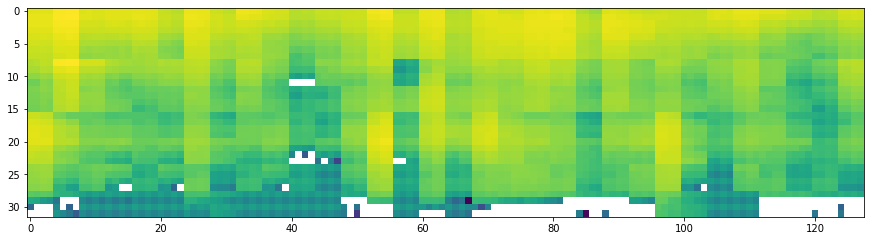



track 18


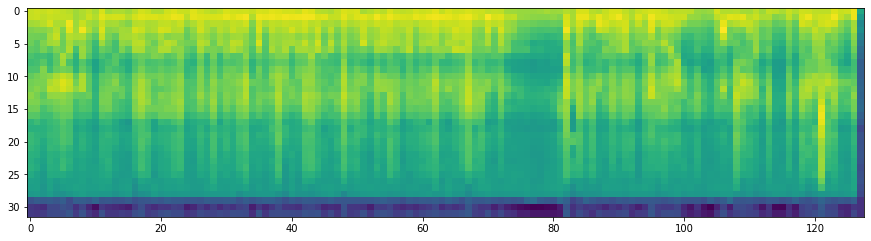

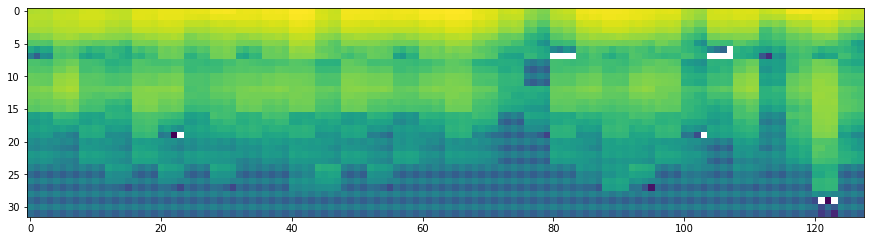



track 19


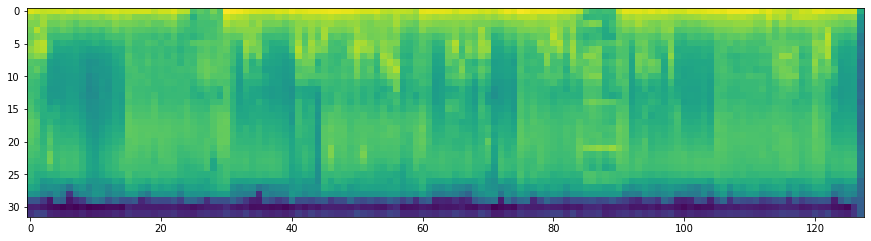

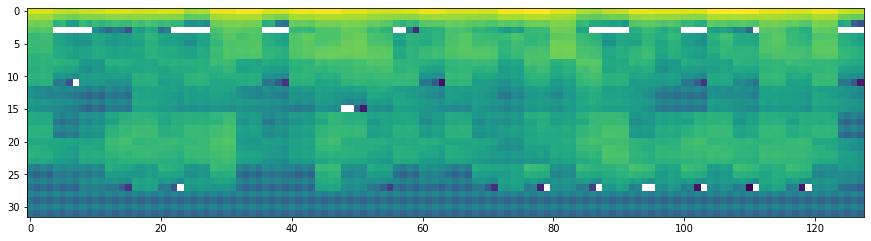



track 20


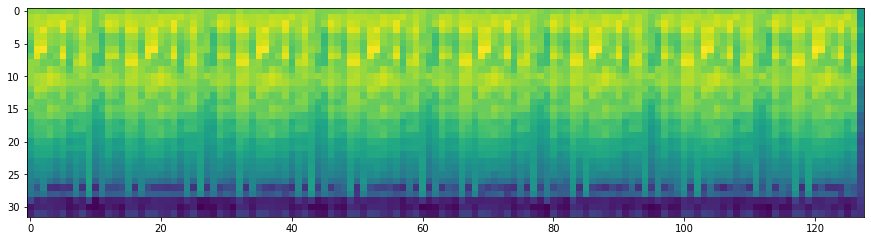

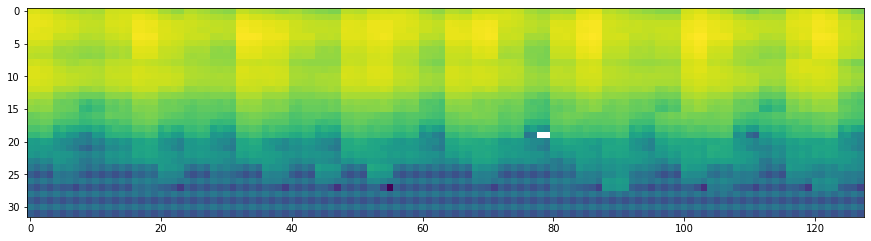



track 21


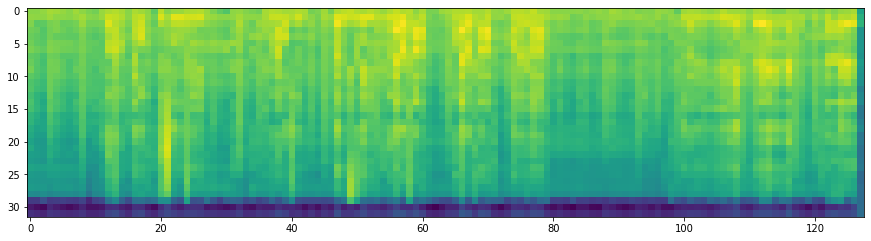

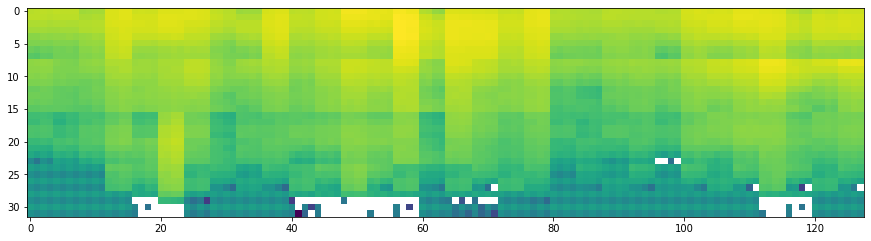



track 22


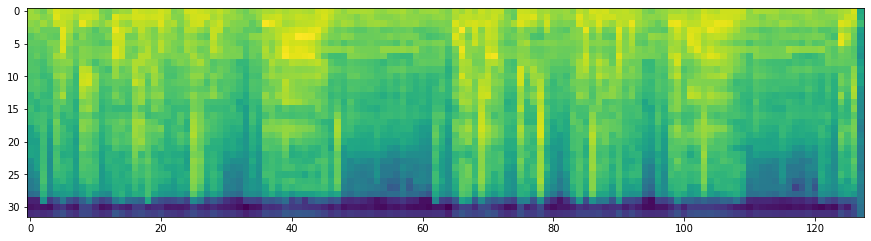

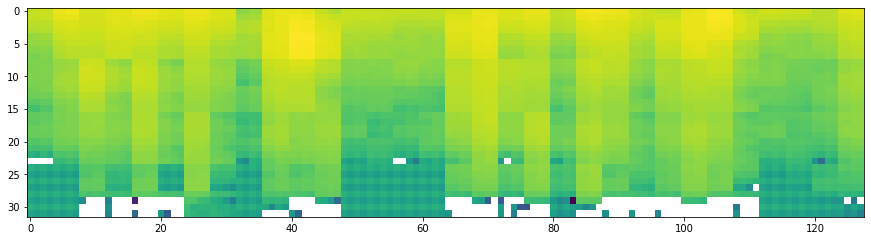



track 23


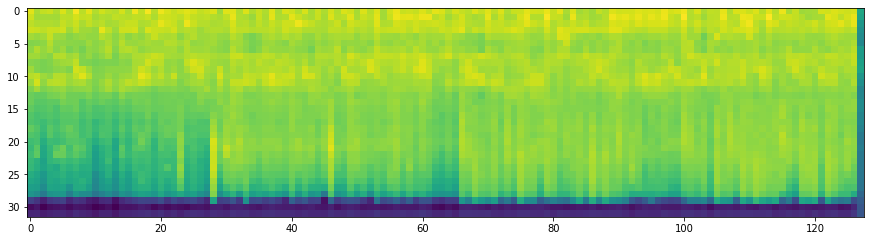

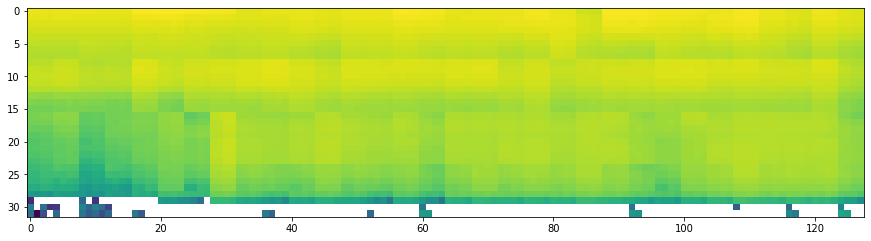



track 24


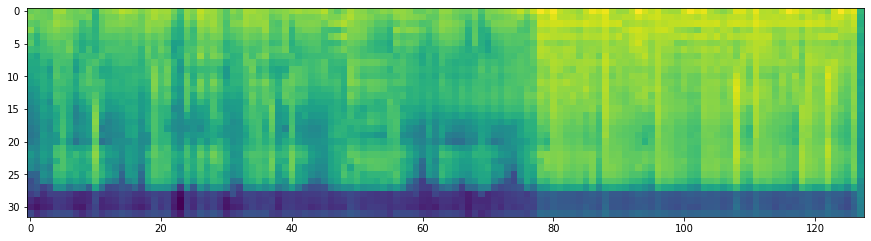

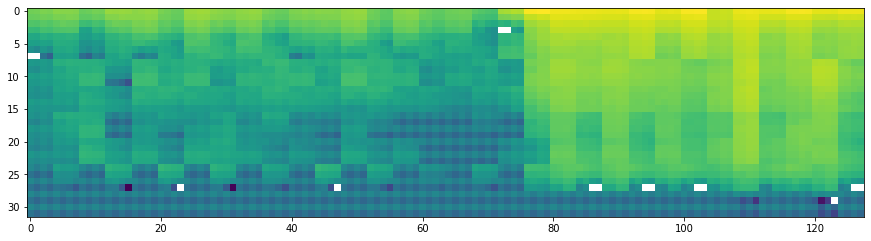



track 25


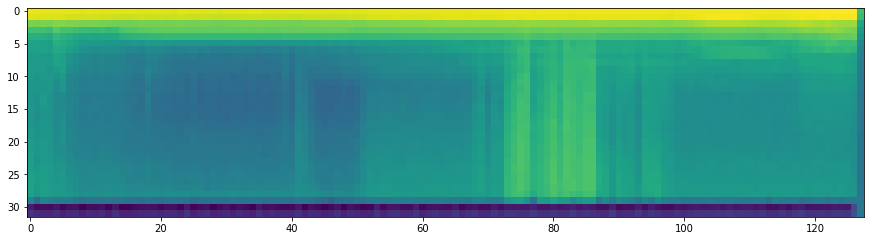

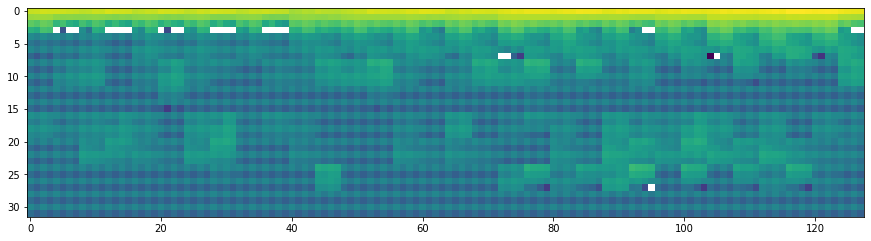



track 26


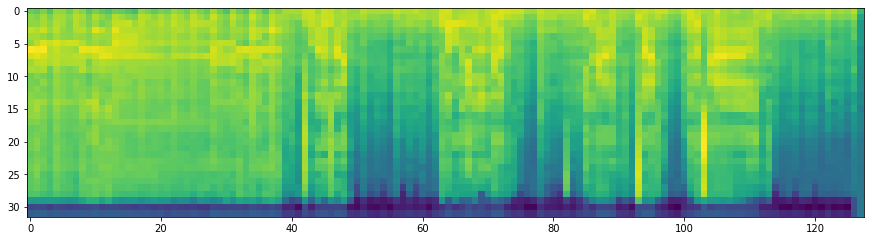

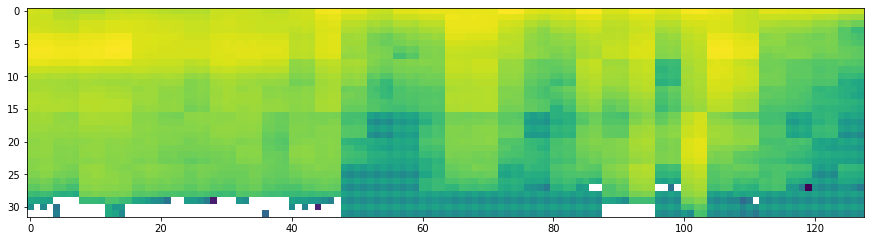



track 27


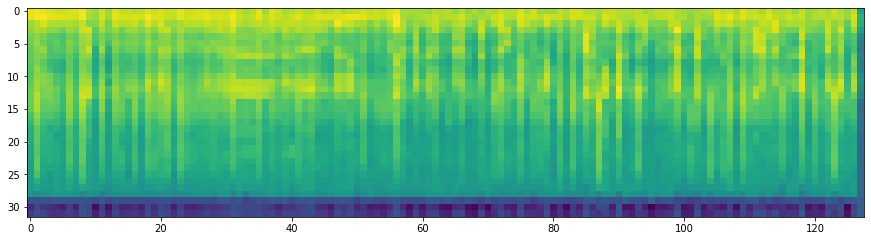

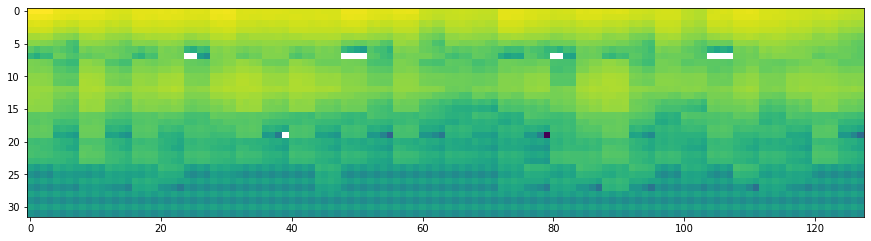



track 28


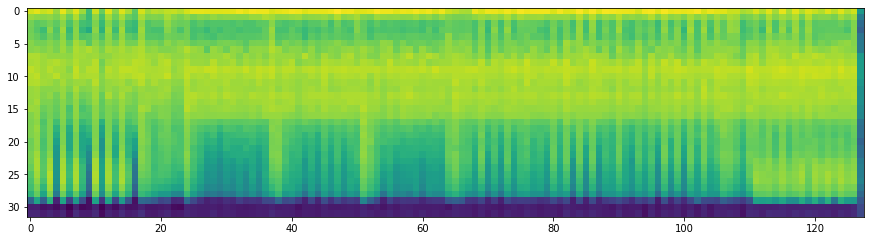

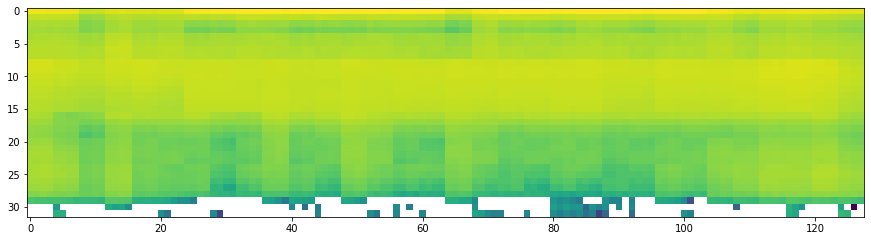



track 29


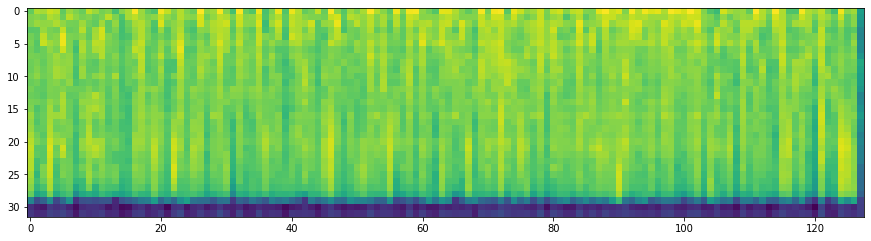

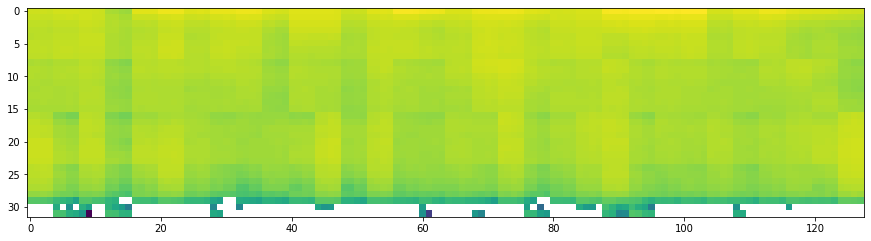



track 30


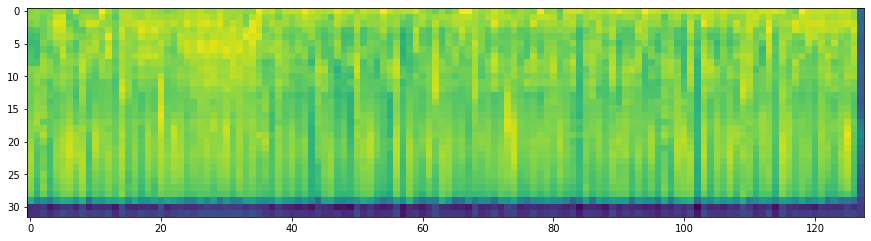

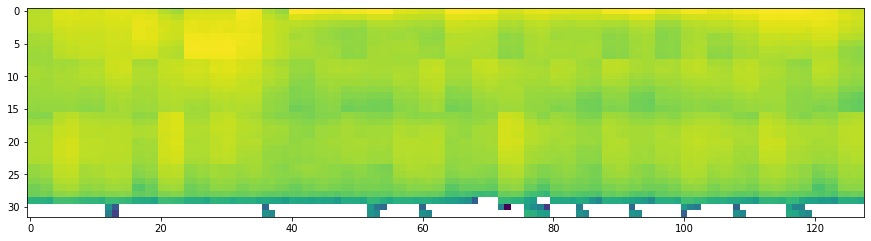



track 31


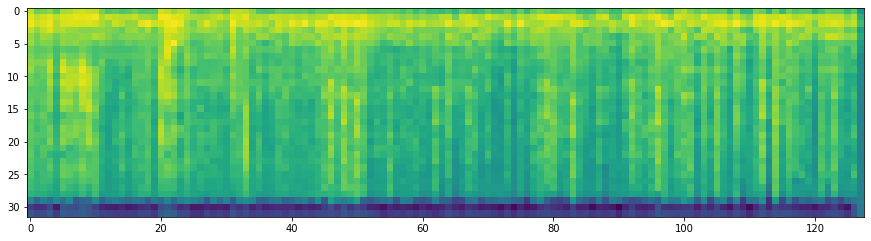

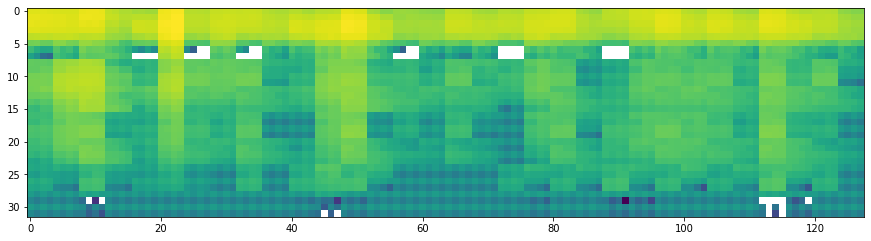



track 32


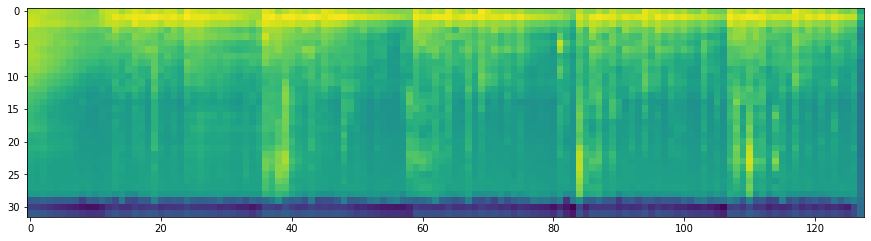

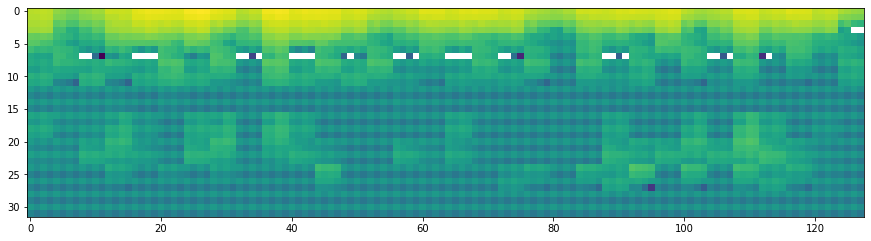



track 33


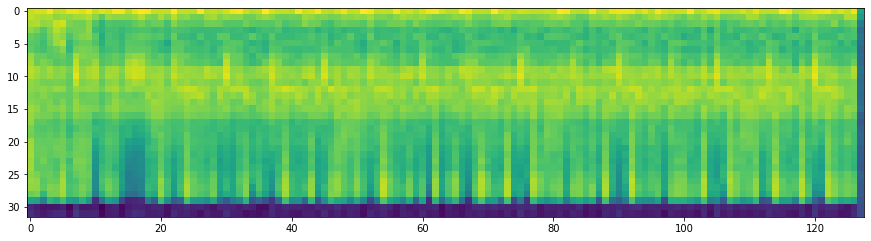

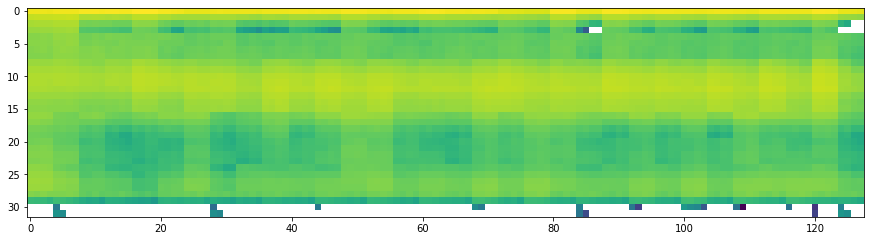



track 34


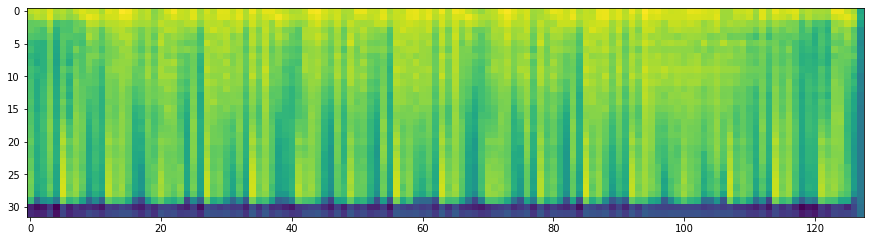

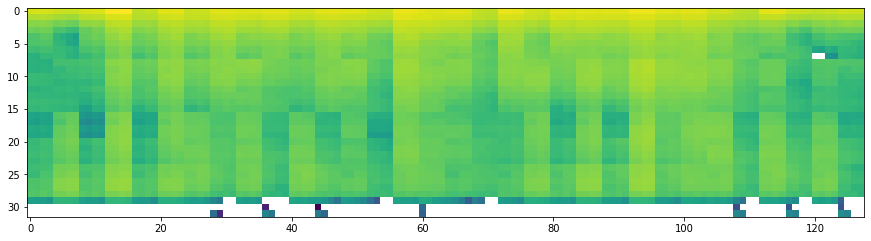



track 35


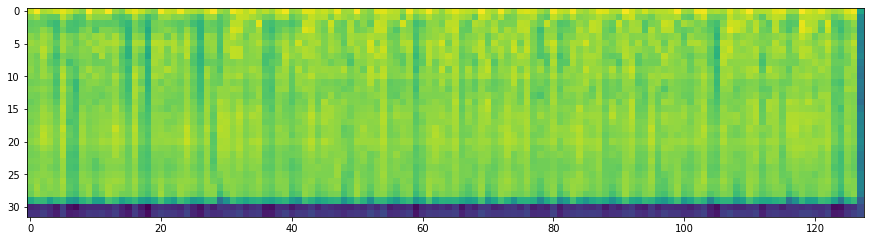

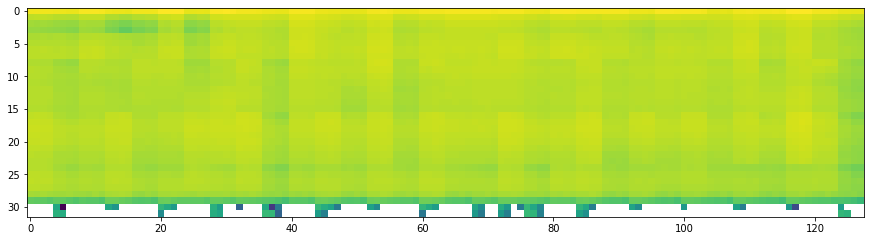



track 36


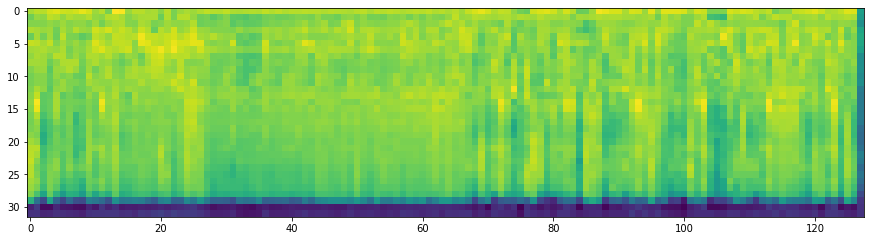

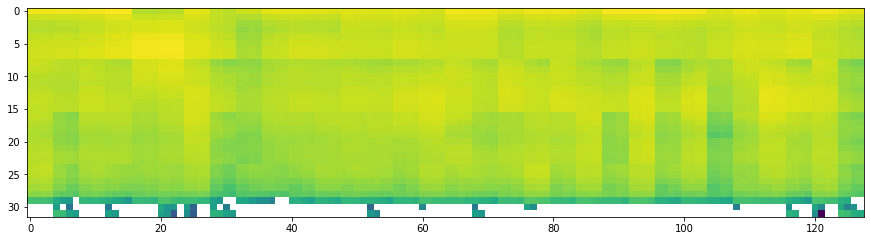



track 37


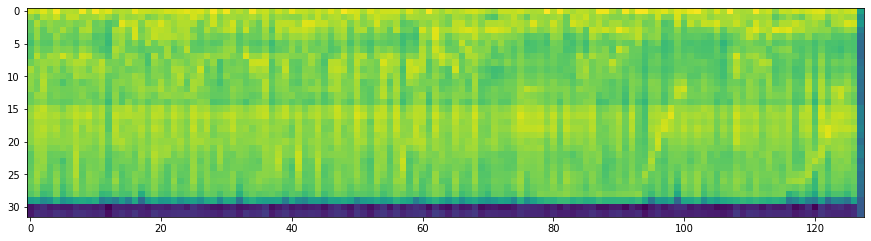

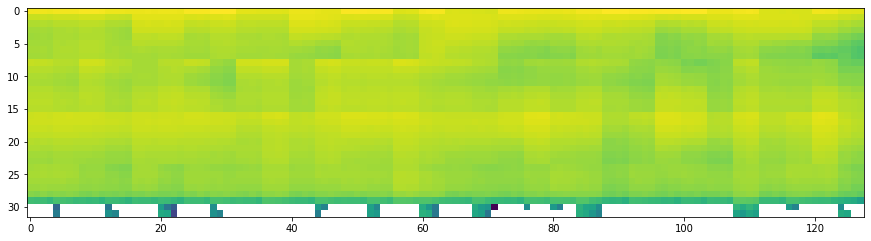



track 38


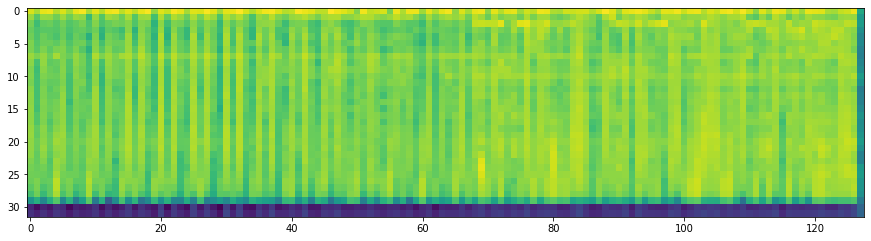

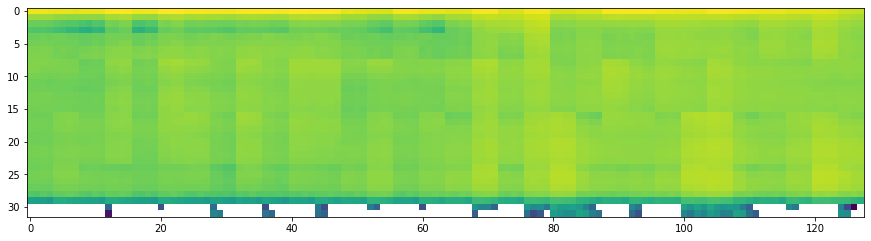



track 39


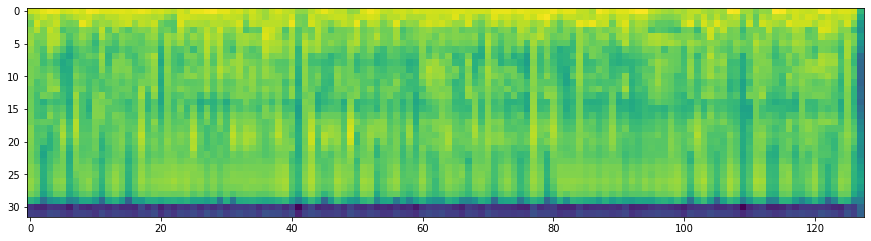

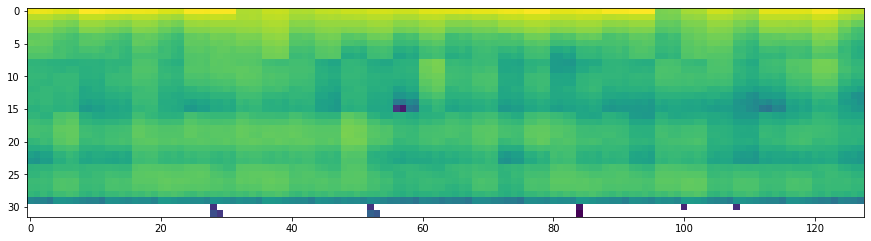



track 40


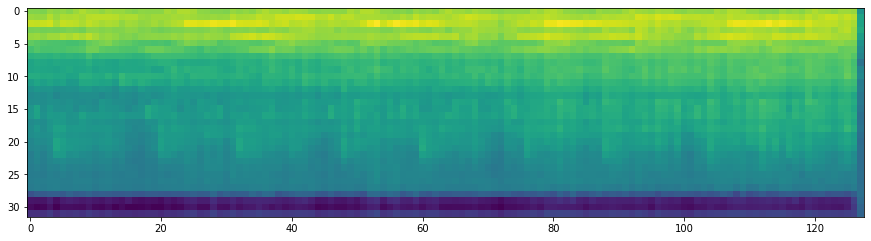

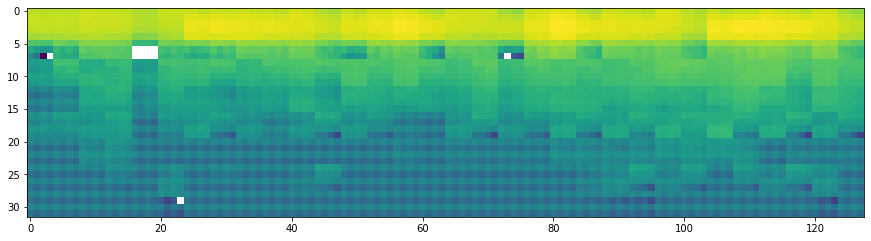



track 41


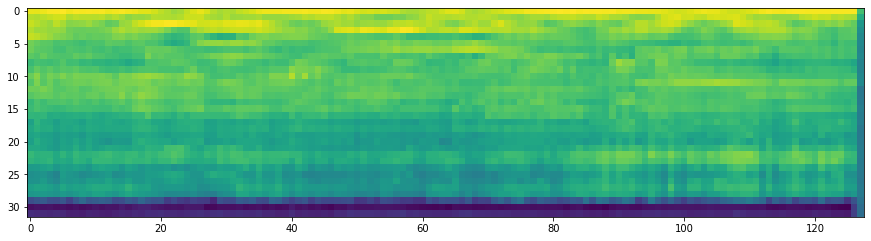

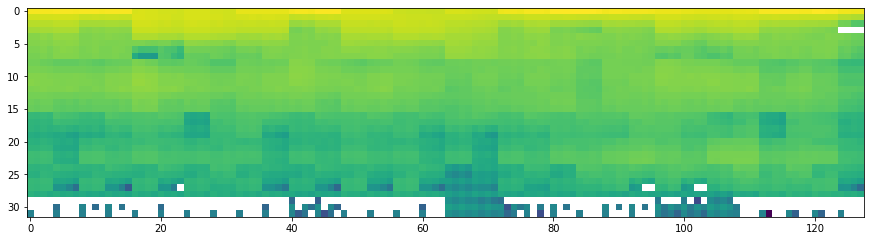



track 42


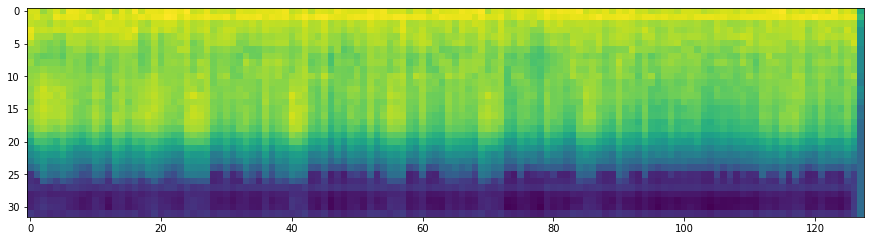

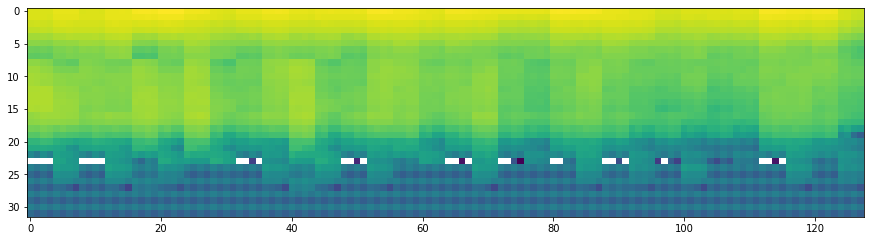



track 43


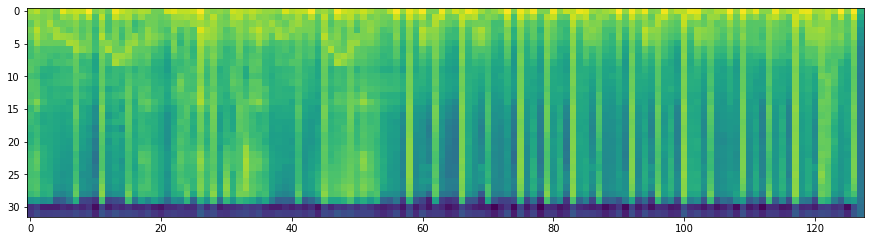

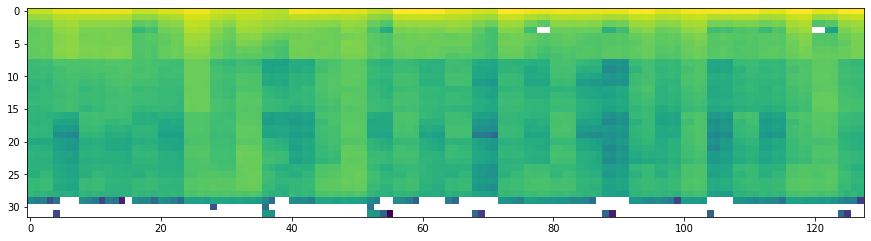



track 44


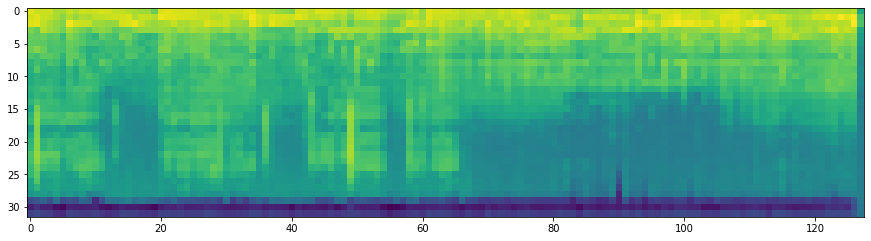

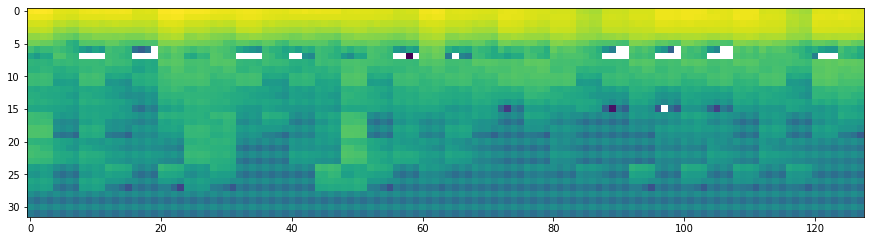



track 45


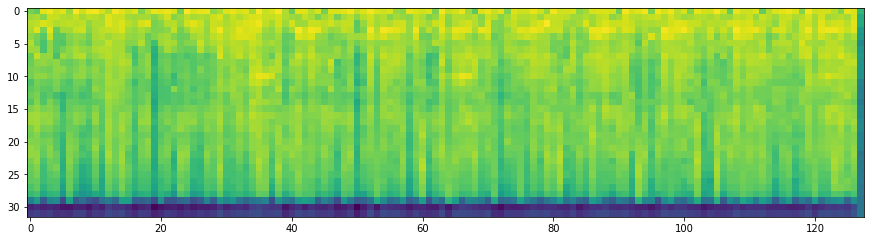

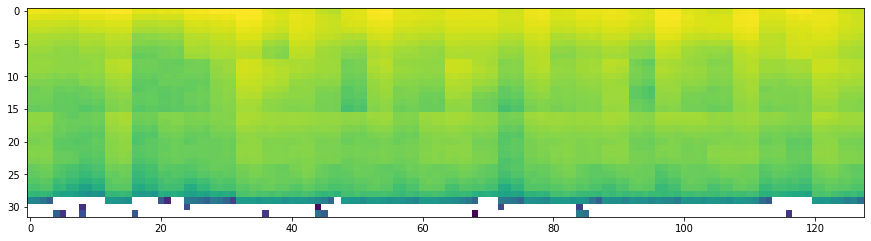



track 46


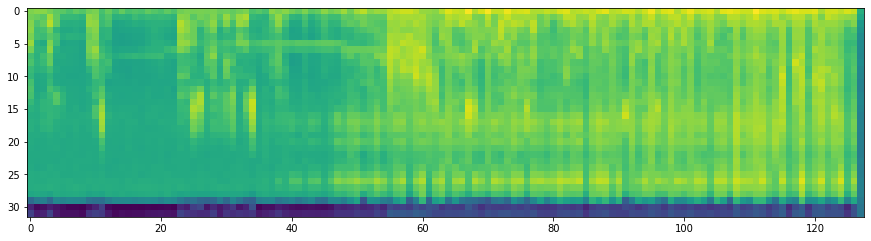

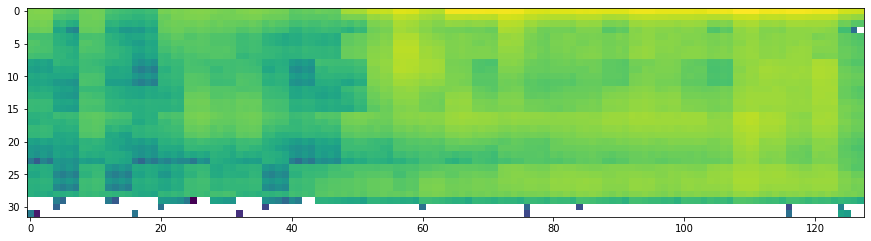



track 47


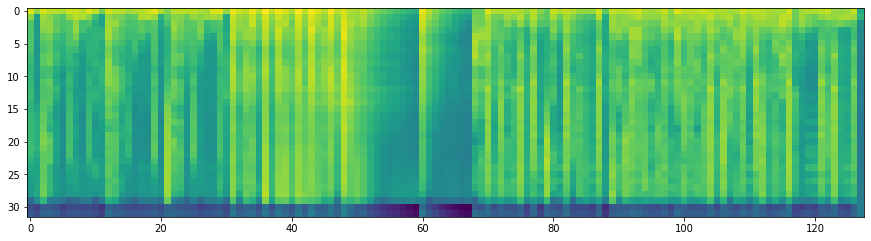

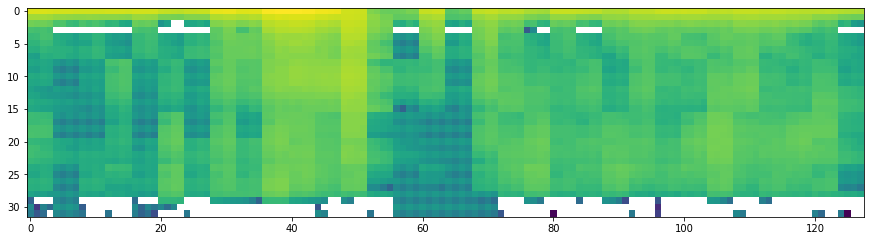



track 48


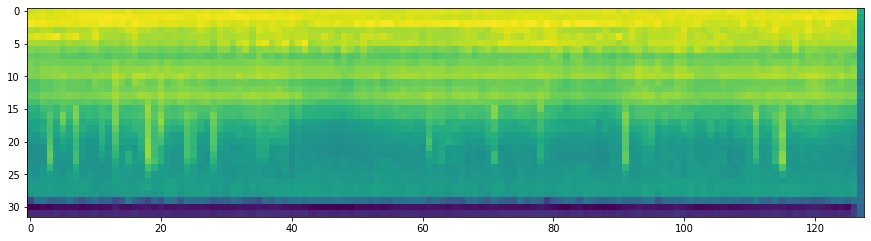

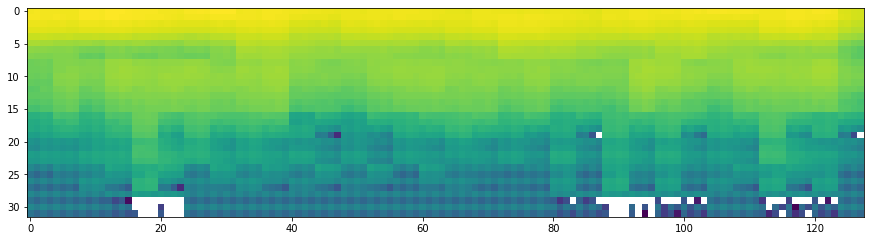



track 49


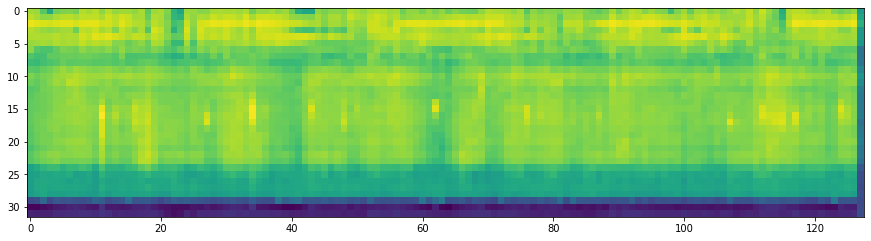

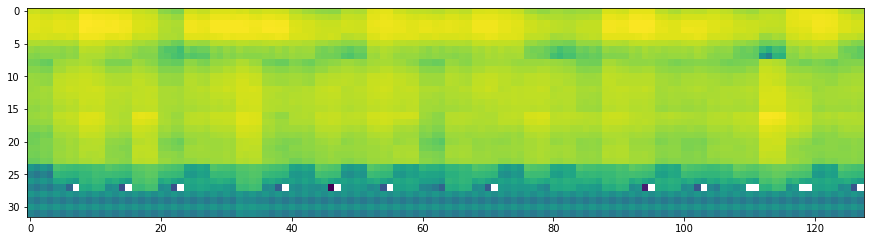



track 50


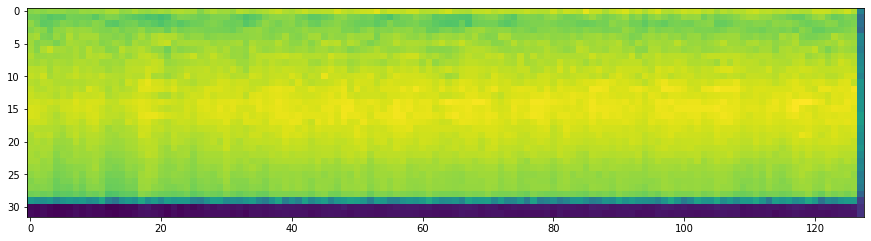

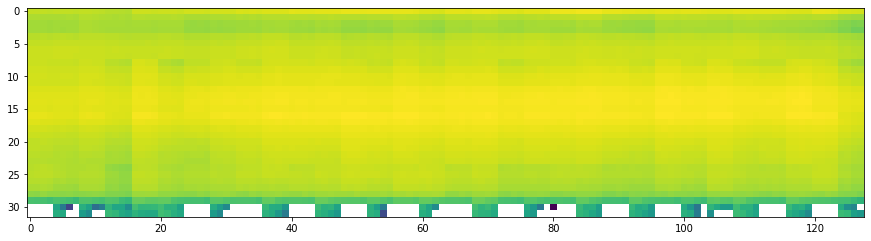



track 51


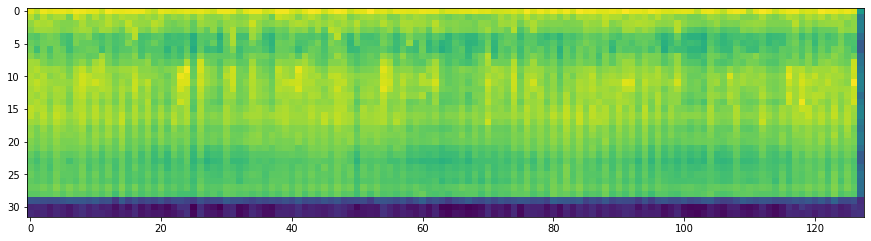

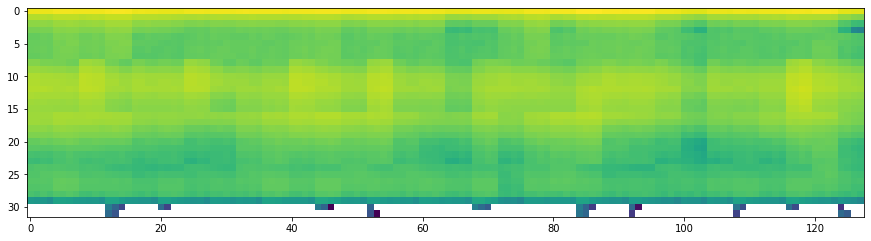



track 52


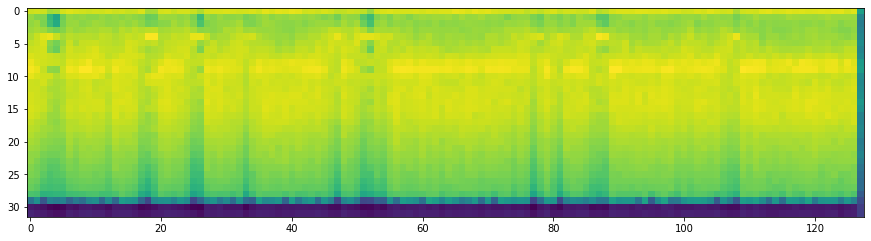

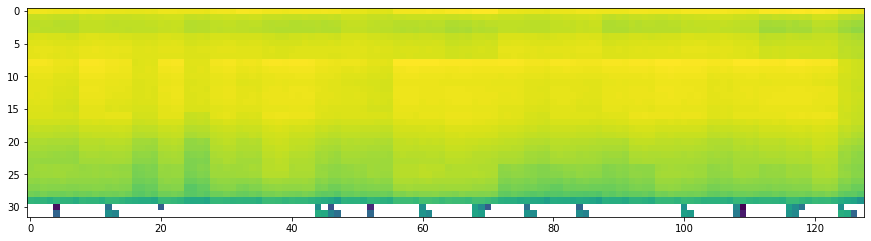



track 53


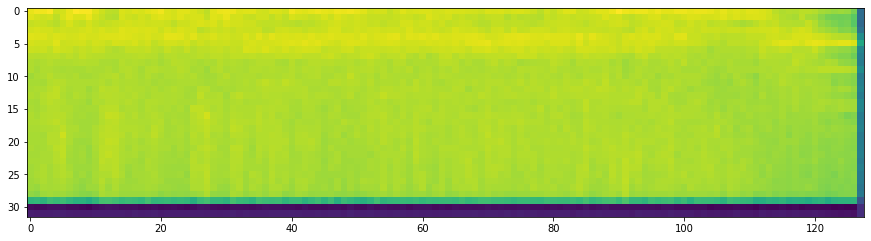

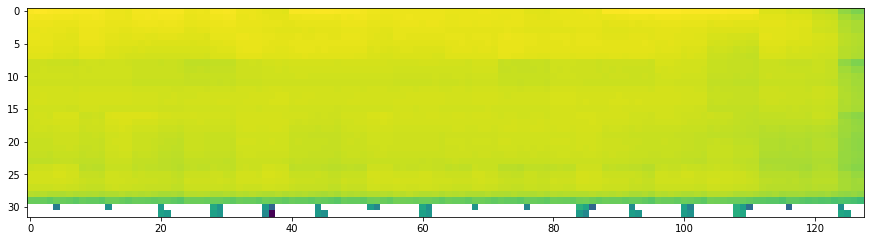



track 54


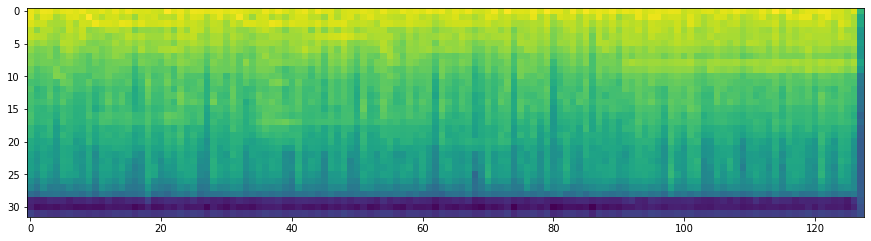

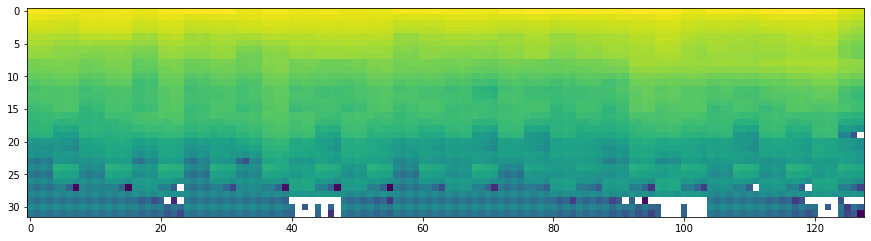



track 55


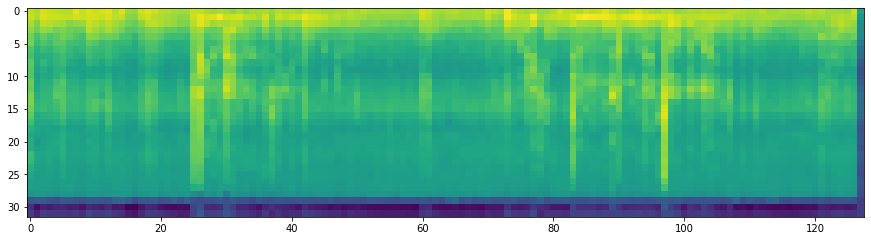

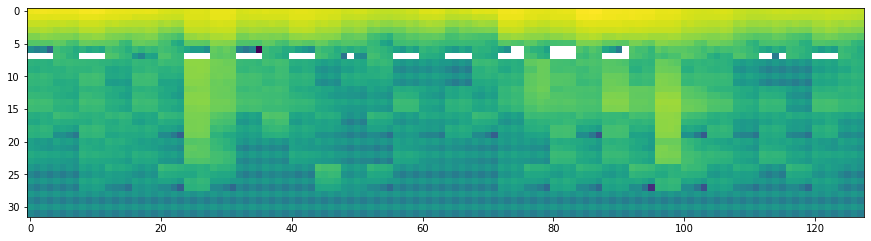



track 56


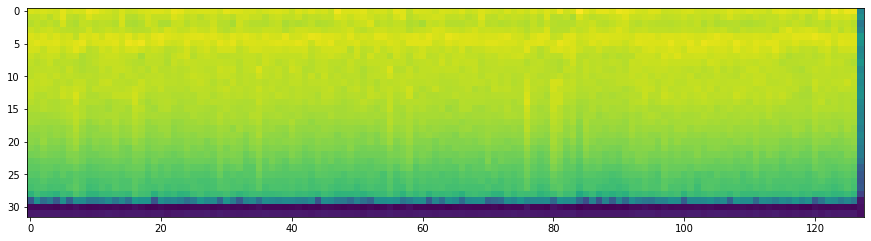

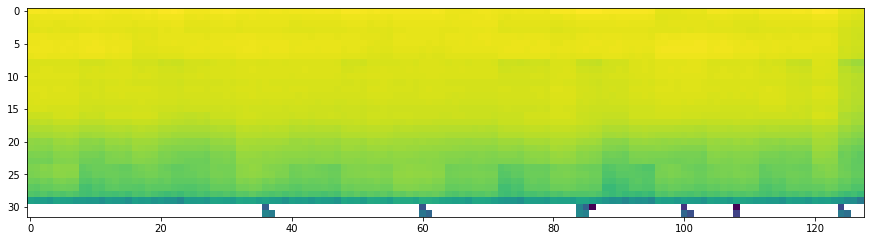



track 57


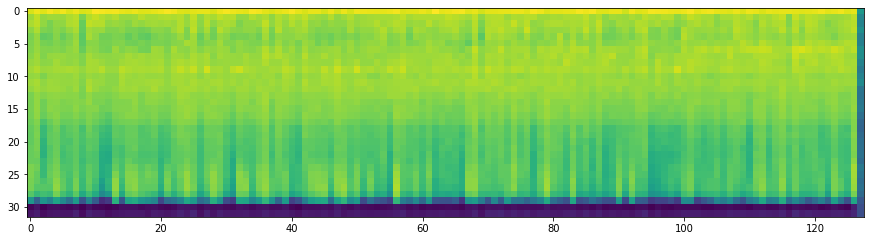

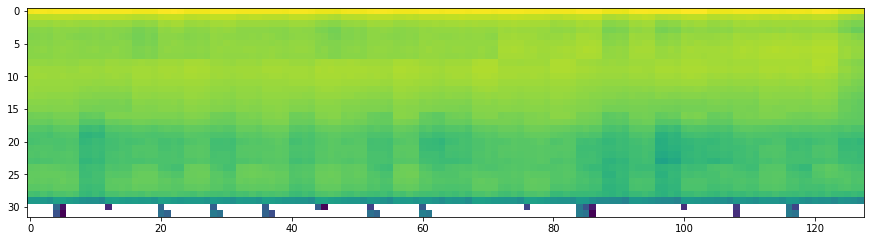



track 58


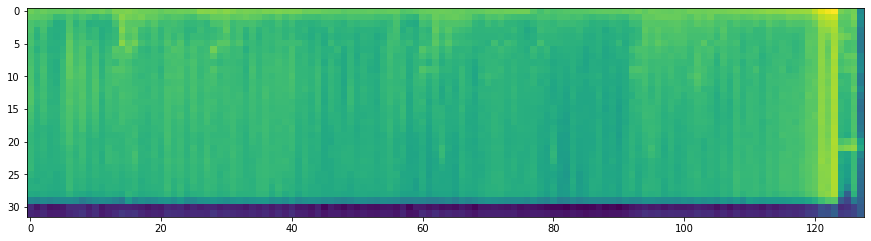

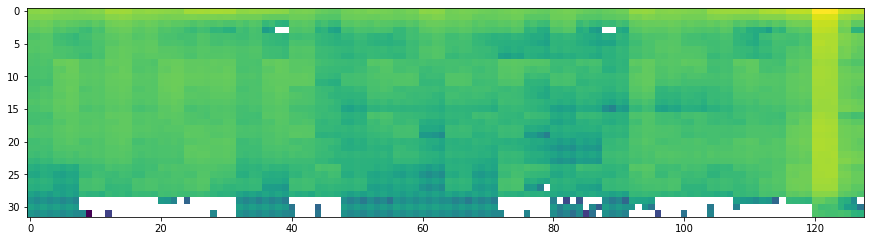



track 59


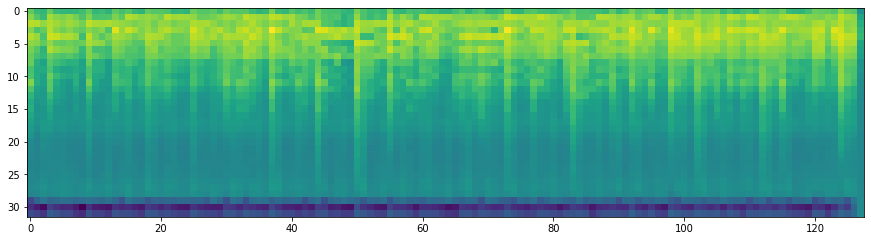

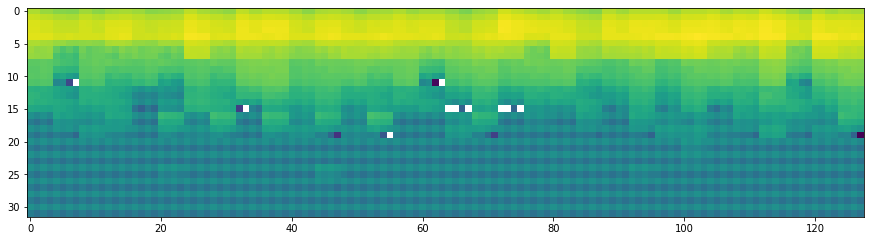



track 60


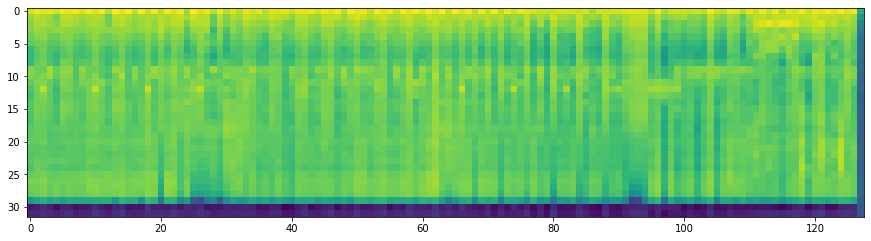

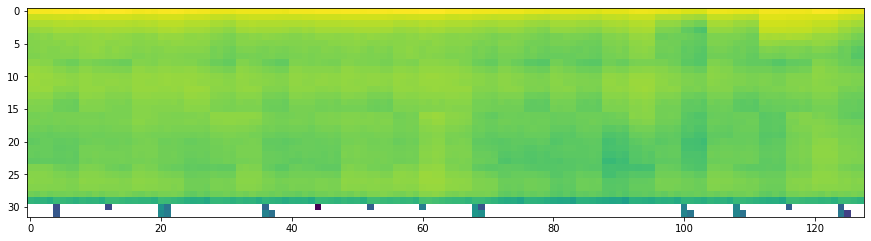



track 61


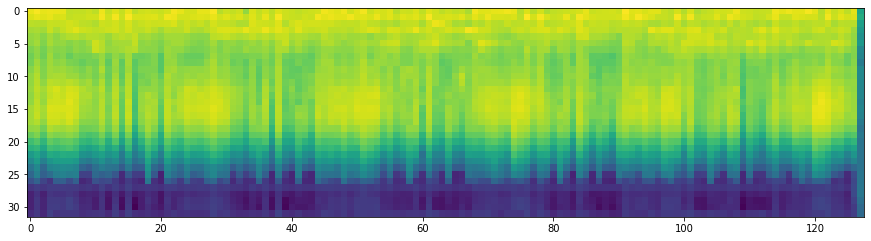

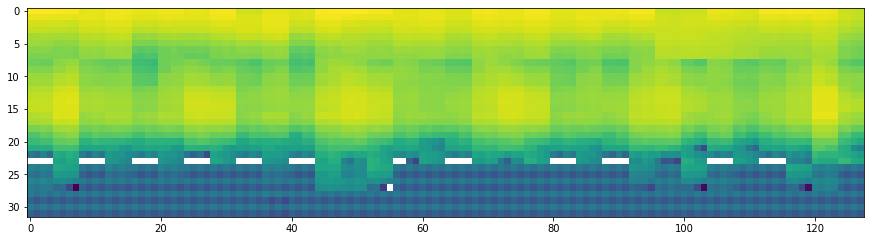



track 62


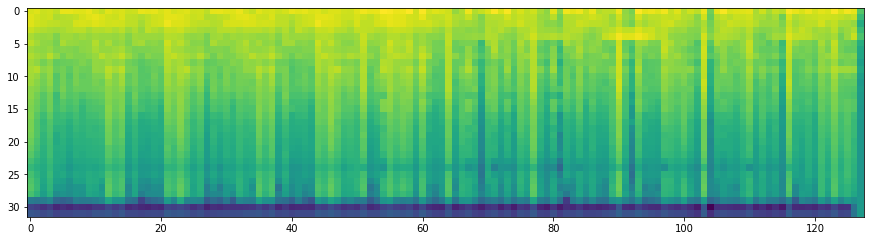

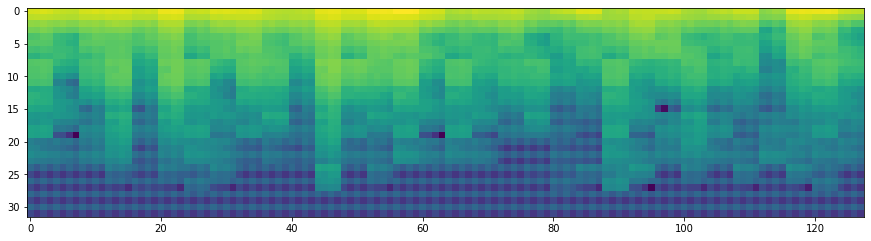



track 63


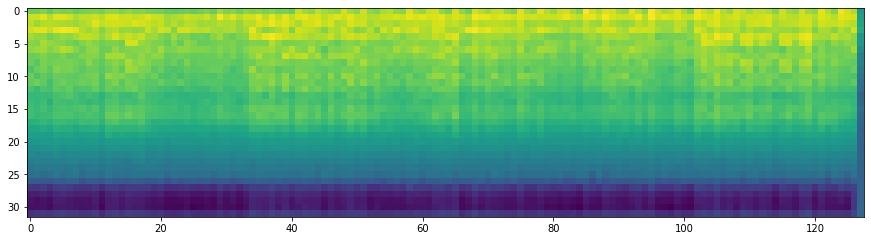

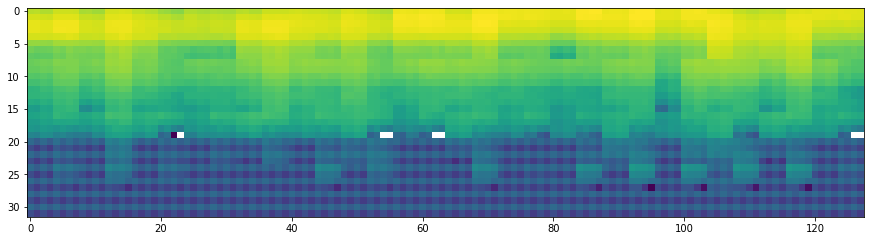

In [ ]:
# Plotting autoencoder predictions and compare to input

batch = next(iter(ds_train))[0]
pred = autoencoder.predict(batch)



for i in range(len(batch)):

    print('track '+str(i))
    plt.figure(figsize=(15,10))
    plt.imshow(tf.math.log(batch[i][:,:,0]*MEL_SCALING).numpy().T)
    plt.show()

    plt.figure(figsize=(15,10))
    plt.imshow(tf.math.log(pred[i][:,:,0]*MEL_SCALING).numpy().T)
    plt.show()
    print('\n')

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE

def plot_3d_embedding(embedding,
                      list_of_labels):
  
  # Reducing dimensions using TSNE
  X_embedded = TSNE(n_components=3, learning_rate='auto',
                  init='random').fit_transform(embedding)

  # 3d plot 
  fig = px.scatter_3d(X_embedded, x=X_embedded[:,0], y=X_embedded[:,1], z=X_embedded[:,2],
                color=list_of_labels)
  fig.show()


In [ ]:
# Using the encoder only to predict to extract latent space information
pred = encoder.predict(ds_train)

In [ ]:
# Checking latent dimension shape
pred[0].shape

(256,)

In [ ]:
# plotting 3D TSNE of latent space embedding with genre colour coding of genres  
df_pred = pd.DataFrame(pred)
df_pred=df_pred.set_index('track_id')

In [ ]:
plot_3d_embedding(df_pred,df['genre_top'])